In [1]:
using NeutrinoTelescopes
using Flux
using CUDA
using Random
using StaticArrays
using BSON: @save, @load
using BSON
using CairoMakie
using Rotations
using LinearAlgebra
using DataFrames
using Zygote
using PoissonRandom
using SpecialFunctions
using StatsBase
using Base.Iterators
using Distributions
using Optim
using LogExpFunctions
using Base.Iterators
using Formatting

In [56]:
mutable struct ModelParam{T<:Number, LB<:Number, UB <:Number}
    name::String
    value::T
    active::Bool
    bounds::Tuple{LB, UB}
end

mutable struct Model
    params::Vector{ModelParam}
end

params(m::Model) = m.params
free_params(m::Model) = [p for p in params(m) if p.active]
get_lower_bounds(m::Model) = [p.bounds[1] for p in free_params(m)]
get_upper_bounds(m::Model) = [p.bounds[2] for p in free_params(m)]
get_seeds(m::Model) = [p.value for p in free_params(m)]

function get_param(m::Model, name::String)
    fp = nothing
    for p in params(m)
        if p.name == name
            fp = p
        end
    end

    if isnothing(fp)
        error("Parameter $name not found in model")
    end

    return fp
end

function set_inactive!(m::Model, name::String)
    p = get_param(m, name)
    p.active = false
end

function set_active!(m::Model, name::String)
    p = get_param(m, name)
    p.active = true
end

function parse_model_params(x, model)

    @assert length(x) == length(free_params(model))
    
    fix = 1
    mparams = params(model)

    parsed = []
    for par in mparams
        if mparams[fix].active
            val = x[fix]
            fix +=1
        else
            val = par.value
        end

        push!(parsed, val)
    end
    return parsed
end

function make_cascade_fit_model(;seed_log_energy=3., seed_zenith=0.5, seed_azimuth=0.5, seed_x=0., seed_y=0., seed_z=0., seed_time=0.)
    logenergy = ModelParam("logenergy", seed_log_energy, true, (2., 5.))
    zenith = ModelParam("zenith", seed_zenith, true, (0., π))
    
    azimuth = ModelParam("azimuth", seed_azimuth, true, (seed_azimuth-π., seed_azimuth+π))
    #azimuth = ModelParam("azimuth", seed_azimuth, true, (0., 2*π))
    pos_x = ModelParam("pos_x", seed_x, true, (-100., 100.))
    pos_y = ModelParam("pos_y", seed_y, true, (-100., 100.))
    pos_z = ModelParam("pos_z", seed_z, true, (-100., 100.))
    time = ModelParam("time", seed_time, true, (-50., 100.))
    return Model([logenergy, zenith, azimuth, pos_x, pos_y, pos_z, time])
end


ErrorException: syntax: unexpected ","

In [57]:
function min_lh(fit_model, samples, targets, model, tf_vec)

    function _func(x)
        logenergy, theta, phi, pos_x, pos_y, pos_z, time = parse_model_params(x, fit_model)
        fval =  -single_cascade_likelihood(logenergy, theta, phi, SA[pos_x, pos_y, pos_z], time; samples=samples, targets=targets, model=model, tf_vec=tf_vec)
        return fval
    end

    
    lower = get_lower_bounds(fit_model)
    upper = get_upper_bounds(fit_model)
    seeds = get_seeds(fit_model)

    inner_optimizer = ConjugateGradient()
    results  = optimize(_func, lower, upper, seeds, Fminbox(inner_optimizer); autodiff=:forward)
    
    #results  = optimize(_func, lower, upper, seeds, SAMIN(rt=0.5), Optim.Options(iterations=10^6))
    
    
    return results
end

function calc_resolution_maxlh(targets, sampling_model, eval_model, n; energy=1E4, zenith=0.1, phi=0.1, position=SA[3., 10., 15.], time=0.)
    
    rng = MersenneTwister(31338)
    hypo = make_cascade_fit_model(seed_x=position[1], seed_y=position[2], seed_z=position[3], seed_time=time)
    set_inactive!(hypo, "pos_x")
    set_inactive!(hypo, "pos_y")
    set_inactive!(hypo, "pos_z")
    set_inactive!(hypo, "time")
    min_vals = []
    for _ in 1:n
        samples = sample_cascade_event(energy, zenith, phi, position, time; targets=targets, model=sampling_model[:model], tf_vec=sampling_model[:tf_dict], rng=rng)
        res = min_lh(hypo, samples, targets, eval_model[:model], eval_model[:tf_dict])    
        push!(min_vals, Optim.minimizer(res))
    end
    min_vals = reduce(hcat, min_vals)

    return min_vals
end

calc_resolution_maxlh(targets, model, n) = calc_resolution_maxlh(targets, model, model, n)



function mc_expectation(particles::AbstractVector{<:Particle}, targets::AbstractVector{<:MultiPMTDetector}, seed)
    
    wl_range = (300.0f0, 800.0f0)
    medium = make_cascadia_medium_properties(0.99f0)
    spectrum = CherenkovSpectrum(wl_range, 30, medium)

    sources = [ExtendedCherenkovEmitter(convert(Particle{Float32}, p), medium, wl_range) for p in particles]

    targets_c::Vector{MultiPMTDetector{Float32}} = targets

    photon_setup = PhotonPropSetup(sources, targets_c, medium, spectrum, seed)
    photons = propagate_photons(photon_setup)

    calc_total_weight!(photons, photon_setup)
    calc_time_residual!(photons, photon_setup)

    rot = RotMatrix3(I)
    hits = make_hits_from_photons(photons, photon_setup, rot)
    return hits
end


function compare_mc_model(
    particles::AbstractVector{<:Particle},
    targets::AbstractVector{<:PhotonTarget},
    models::Dict,
    hits)
    
    times = -10:1:100
    fig = Figure(resolution=(1000, 700))
    ga = fig[1, 1] = GridLayout(4, 4)

    for i in 1:16
        row, col = divrem(i - 1, 4)
        mask = hits[:, :pmt_id] .== i
        ax = Axis(ga[col+1, row+1], xlabel="Time Residual(ns)", ylabel="Photons / time", title="PMT $i")
        hist!(ax, hits[mask, :tres], bins=-10:5:100, weights=hits[mask, :total_weight], color=:orange, normalization=:density)
    end

    for (mname, model_path) in models
        @load model_path model hparams opt tf_dict
        input = calc_flow_input(particles, targets, tf_dict)
        log_pdf, log_expec = model(repeat(times, size(input, 2)), repeat(input, inner=(1, length(times))), true)
        log_pdf = reshape(log_pdf, length(times), size(input, 2),)
        log_expec = reshape(log_expec, length(times), size(input, 2),)
    
        for i in 1:16
            row, col = divrem(i - 1, 4)
            lines!(ga[col+1, row+1], times, exp.(log_pdf[:, i] + log_expec[:, i]), label=mname)
        end
    end

    fig
end

compare_mc_model(particles, targets, models) =  compare_mc_model(particles, targets, models, mc_expectation(particles, targets))

compare_mc_model (generic function with 2 methods)

In [4]:
models = Dict(
    "1" => joinpath(@__DIR__, "../assets/rq_spline_model_l2_0_1_FNL.bson"),
    "2" => joinpath(@__DIR__, "../assets/rq_spline_model_l2_0_2_FNL.bson"),
    "3" => joinpath(@__DIR__, "../assets/rq_spline_model_l2_0_3_FNL.bson"),
    "4" => joinpath(@__DIR__, "../assets/rq_spline_model_l2_0_4_FNL.bson"),
    "5" => joinpath(@__DIR__, "../assets/rq_spline_model_l2_0_5_FNL.bson"),
    "FULL" => joinpath(@__DIR__, "../assets/rq_spline_model_l2_0_FULL_FNL.bson")
)
    


target = make_pone_module(@SVector[0.0, 0.0, 0.0], 1)
targets = make_detector_line(@SVector[0.0, 0.0, 0.0], 20, 50)
#targets = make_hex_detector(3, 50, 20, 50, truncate=1)


20-element Vector{MultiPMTDetector{Float64, 16, 32}}:
 MultiPMTDetector{Float64, 16, 32}([0.0, 0.0, 0.0], 0.21, 0.004417864669110647, [1.9605149980656156 1.1810776555241778 … 1.1810776555241778 1.9605149980656154; 0.4232502807774416 0.42325028077744165 … -2.718342372812352 -2.7183423728123515], 0x0002)
 MultiPMTDetector{Float64, 16, 32}([0.0, 0.0, -50.0], 0.21, 0.004417864669110647, [1.9605149980656156 1.1810776555241778 … 1.1810776555241778 1.9605149980656154; 0.4232502807774416 0.42325028077744165 … -2.718342372812352 -2.7183423728123515], 0x0003)
 MultiPMTDetector{Float64, 16, 32}([0.0, 0.0, -100.0], 0.21, 0.004417864669110647, [1.9605149980656156 1.1810776555241778 … 1.1810776555241778 1.9605149980656154; 0.4232502807774416 0.42325028077744165 … -2.718342372812352 -2.7183423728123515], 0x0004)
 MultiPMTDetector{Float64, 16, 32}([0.0, 0.0, -150.0], 0.21, 0.004417864669110647, [1.9605149980656156 1.1810776555241778 … 1.1810776555241778 1.9605149980656154; 0.4232502807774416 0.4232502

In [59]:
@load models["4"] model hparams opt tf_dict
pos = SA[-10., 5., 10.]
theta = 0.5
phi = 0.1
targets_range = [t for t in targets if norm(t.position .- pos) < 200]


samples = sample_cascade_event(5E4, theta, phi, pos, 0.; targets=targets_range, model=model, tf_vec=tf_dict, rng=Random.GLOBAL_RNG)
hypo = make_cascade_fit_model(seed_x=pos[1], seed_y=pos[2], seed_z=pos[3], seed_time=0.)
res = min_lh(hypo, samples, targets_range, model, tf_dict)
minvals = Optim.minimizer(res)
@show minvals

les = 4:0.01:5.5
zens = 0.4:0.01:0.6
azis = 0:0.01:0.2

fig = Figure(resolution=(1500, 500))
ax1 = Axis(fig[1, 1])
llhs = [single_cascade_likelihood(le, theta, phi, pos, 0.; samples=samples, targets=targets_range, model=model, tf_vec=tf_dict) for le in les]
lines!(ax1, les, llhs)
vlines!(ax1, [log10(5E4), minvals[1]], color=[:red, :black])


ax2 = Axis(fig[1, 2])
llhs = [single_cascade_likelihood(log10(5E4), zen, phi, pos, 0.; samples=samples, targets=targets_range, model=model, tf_vec=tf_dict) for zen in zens]
lines!(ax2, zens, llhs)
vlines!(ax2, [theta, minvals[2]], color=[:red, :black])

ax3 = Axis(fig[1, 3])
llhs = [single_cascade_likelihood(log10(5E4), theta, azi, pos, 0.; samples=samples, targets=targets_range, model=model, tf_vec=tf_dict) for azi in azis]
lines!(ax3, azis, llhs)
vlines!(ax3, [phi, minvals[3]], color=[:red, :black])







fig

minvals = [4.581850312789539, 0.6943792240380172, 0.5441607389901466, -9.48140182913068, 3.4741244650761725, 9.899185769765895, 0.767932931809429]


UndefVarError: UndefVarError: azi not defined

In [65]:
zens = 0.3:0.005:0.7
azis = -0.2:0.005:0.2

llh2d = single_cascade_likelihood.(log10(5E4), zens, permutedims(azis), Ref(pos), 0.; samples=samples, targets=targets_range, model=model, tf_vec=tf_dict)
heatmap(zens, azis, llh2d)

In [30]:


Flux.testmode!(model)

pos = SA[-10., 5., 10.]
targets_range = [t for t in targets if norm(t.position .- pos) < 200]
targets_range = [target]

samples = sample_cascade_event(5E4, 0.2, 0.1, pos, 0.; targets=targets_range, model=model, tf_vec=tf_dict, rng=Random.GLOBAL_RNG)
hypo = make_cascade_fit_model(seed_x=-10., seed_y=10., seed_z=10., seed_time=0.)



res = min_lh(hypo, samples, targets_range, model, tf_dict)
minvals = Optim.minimizer(res)



3-element Vector{Float64}:
 4.866440024474234
 0.06436749890309053
 1.3574762524214475e-5

In [46]:
targets_range = [t for t in targets if norm(t.position .- pos) < 200]
model_res = Dict()
for (mname, model_path) in models
    m = BSON.load(model_path)
    Flux.testmode!(m[:model])
    res = calc_resolution_maxlh(targets_range, m, 200)
    model_res[mname] = res
end

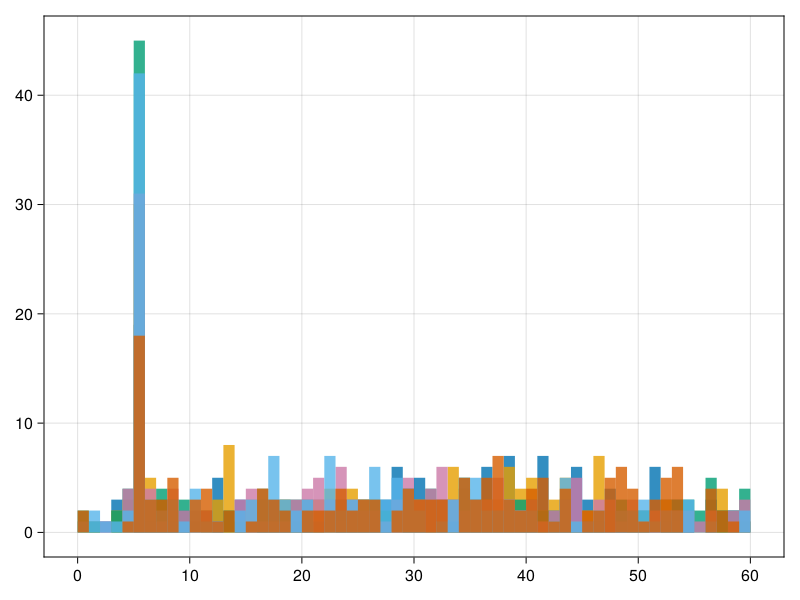

In [48]:
fig = Figure()
ax = Axis(fig[1, 1])

bins = 0:1:60

for (k, v) in model_res

    hist!(ax, rad2deg.(acos.(dot.(sph_to_cart.(v[2, :], v[3, :]), Ref(sph_to_cart(0.1, 0.1))))),
    label=k, bins=bins)

end
fig